In [31]:
# change to the working path
import os
os.chdir('/Users/yinancheng/Documents/Project/TrustworthyAI/Advertisement/')

Load data

In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

path = 'Data' # Path of the dataset folder

df_feeds = pd.read_csv(path + '/train/train_data_feeds.csv') #feeds data
df_ads = pd.read_csv(path + '/train/train_data_ads.csv') # ads data
 
print(df_feeds.shape)
print(df_ads.shape)

(3227732, 28)
(7675517, 35)


Last touch point matching

In [33]:
user_ads = df_ads['user_id'].unique() #get potential customer's user id

#feeds data: select potential customers and sort by timestamp
df_feeds_pot = df_feeds[df_feeds['u_userId'].isin(user_ads)].sort_values(by='e_et')

#ads data: sort by timestamp
df_ads = df_ads.sort_values(by = 'pt_d')
#merge above selected data via last touch point
df_merged = pd.merge_asof(df_ads, df_feeds_pot, left_on='pt_d', right_on='e_et',\
                          left_by = 'user_id', right_by = 'u_userId', direction='backward')

#shuffle the merged dataset
df_merged = df_merged.sample(frac=1, random_state = 0).reset_index(drop=True)

# 1 Match Rate/Drop Rate Analysis

### 1.1 Whole data

IdHas rate and IdLess rate

In [34]:
df_matched = df_merged.dropna() #matched data/idhas data
idhas_rate = df_matched.shape[0]/df_merged.shape[0]
idless_rate = 1-idhas_rate
print("idhas rate:", idhas_rate)
print("idless rate:",idless_rate)

idhas rate: 0.8307807799787298
idless rate: 0.1692192200212702


### 1.2 Per User

Per-user IdHas rate

In [35]:
#idless rate for each user
idless_rate_user = df_merged.groupby('user_id').apply(lambda x: x.isna().any(axis = 1).mean())
#idhas rate for each user
idhas_rate_user = 1 - idless_rate_user

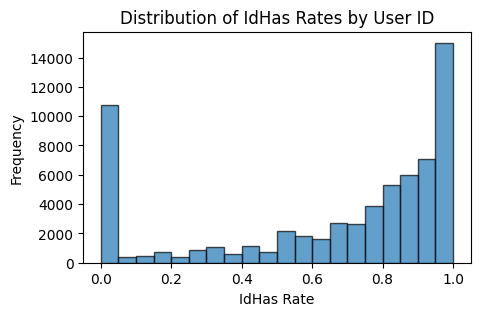

In [36]:
plt.figure(figsize=(5, 3))
plt.hist(idhas_rate_user, bins = 20, edgecolor='k', alpha = 0.7)
plt.title('Distribution of IdHas Rates by User ID')
plt.xlabel('IdHas Rate')
plt.ylabel('Frequency')
plt.show()

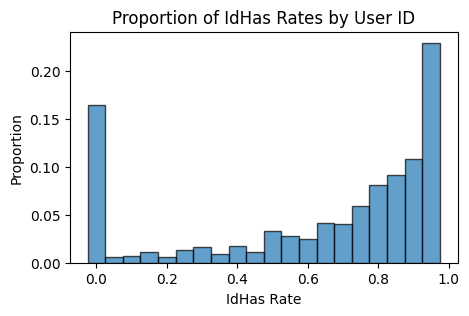

In [37]:
counts, bin_edges = np.histogram(idhas_rate_user, bins=20)

# Calculate proportions for each bin
proportions = counts / counts.sum()

plt.figure(figsize=(5, 3))
plt.bar(bin_edges[:-1], proportions, width=np.diff(bin_edges), edgecolor='k', alpha = 0.7)
plt.title('Proportion of IdHas Rates by User ID')
plt.xlabel('IdHas Rate')
plt.ylabel('Proportion')
plt.show()

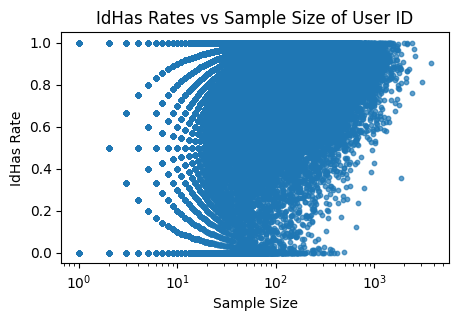

In [38]:
sample_size_user = df_merged['user_id'].value_counts()
combined_df = pd.concat([sample_size_user, idhas_rate_user], axis=1)
combined_df.columns = ['sample_size_user','idhas_rate_user']

plt.figure(figsize=(5, 3))
plt.scatter(combined_df['sample_size_user'], combined_df['idhas_rate_user'], s=10, alpha = 0.7)
plt.title('IdHas Rates vs Sample Size of User ID')
plt.xscale('log')
plt.xlabel('Sample Size')
plt.ylabel('IdHas Rate')
plt.show()

### 1.3 Per Task 

Per-task match rate

In [42]:
idless_rate_task = df_merged.groupby('task_id').apply(lambda x: x.isna().any(axis = 1).mean())
idhas_rate_task = 1 - idless_rate_task

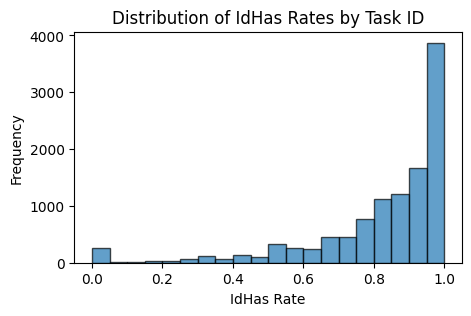

In [43]:
plt.figure(figsize=(5, 3))
plt.hist(idhas_rate_task, bins = 20, edgecolor='k', alpha = 0.7)
plt.title('Distribution of IdHas Rates by Task ID')
plt.xlabel('IdHas Rate')
plt.ylabel('Frequency')
plt.show()

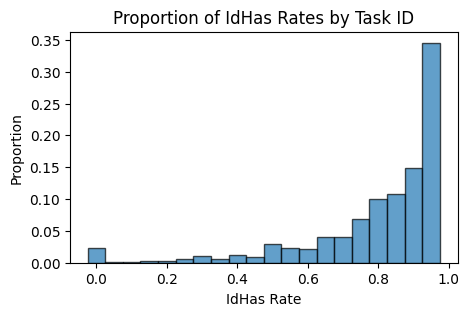

In [44]:
counts, bin_edges = np.histogram(idhas_rate_task, bins=20)

# Calculate proportions for each bin
proportions = counts / counts.sum()

plt.figure(figsize=(5, 3))
plt.bar(bin_edges[:-1], proportions, width=np.diff(bin_edges), edgecolor='k', alpha = 0.7)
plt.title('Proportion of IdHas Rates by Task ID')
plt.xlabel('IdHas Rate')
plt.ylabel('Proportion')
plt.show()

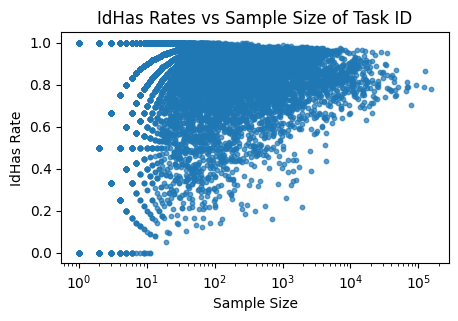

In [45]:
sample_size_task = df_merged['task_id'].value_counts()
combined_df = pd.concat([sample_size_task, idhas_rate_task], axis=1)
combined_df.columns = ['sample_size_task','idhas_rate_task']

plt.figure(figsize=(5, 3))
plt.scatter(combined_df['sample_size_task'], combined_df['idhas_rate_task'], s = 10, alpha = 0.7)
plt.title('IdHas Rates vs Sample Size of Task ID')
plt.xscale('log')
plt.xlabel('Sample Size')
plt.ylabel('IdHas Rate')
plt.show()

# 2 Machine Learning Tasks

In [14]:
columns_to_drop = [column for column in df_merged.columns if df_merged[column].nunique() > 13000 \
                   or df_merged[column].nunique() == 1]
df_merged = df_merged.drop(columns=columns_to_drop)
df_merged = df_merged.select_dtypes(include=[np.number])
#df_merged = df_merged.astype(int)
df_idless = df_merged[df_merged.isna().any(axis=1)]
df_idhas = df_merged.dropna()
idhas_rate = df_idhas.shape[0]/df_merged.shape[0]
idless_rate = df_idless.shape[0]/df_merged.shape[0]
print("idhas rate:",idhas_rate)
print("idless rate:",idless_rate)

idhas rate: 0.8575759782696071
idless rate: 0.1424240217303929


In [15]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from nam.wrapper import NAMClassifier

models = {
    'LR': LogisticRegression(), # not accept nan
    'DT': DecisionTreeClassifier(random_state=0),
    'KNN': KNeighborsClassifier(), # not accept nan
    'NB': GaussianNB(), # not accept nan
    'SVM': SVC(random_state=0, probability=True), # not accept nan
    'RF': RandomForestClassifier(random_state=0),    
    #'GAM': LogisticGAM(), # Does not converge
    'XGB': XGBClassifier()#,
    #'NAM': NAMClassifier()
}

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/nam/trainer/trainer.py:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [16]:
print(df_idless.shape[0])
print(df_idhas.shape[0])

1093178
6582339


## 2.1 Validation dataset: idhas

Split matched data (idhas) into two sets: 1/3 and 2/3 matched data

The validation data (test): 1/3 mathced data (idhas data).

Training data 1: 2/3 matched data
Training data 2: combine 2/3 matched data and all unmatched data (idless) and then draw a sample with the same sample size as traning data 1.

In [17]:
#get test data
test = df_idhas.sample(frac=0.33, random_state=42)
X_test = test.drop('label_x', axis=1)
y_test = test['label_x']

#get training data 1
train_matched = df_idhas.drop(test.index)
#get training data 2
train_merged = pd.concat([train_matched, df_idless])
train_merged = train_merged.sample(n=train_matched.shape[0], random_state=42)

X_train_matched = train_matched.drop('label_x', axis=1)
y_train_matched = train_matched['label_x']
y_test_matched = y_test

X_train_merged = train_merged.drop('label_x', axis=1)
y_train_merged = train_merged['label_x']
y_test_merged = y_test

In [18]:
#standard scaler

from sklearn.preprocessing import StandardScaler 

scaler_merged = StandardScaler()
X_train_merged = scaler_merged.fit_transform(X_train_merged)
X_test_merged = scaler_merged.transform(X_test)

scaler_matched = StandardScaler()
X_train_matched = scaler_matched.fit_transform(X_train_matched)
X_test_matched = scaler_matched.transform(X_test)

In [19]:
#define function to get metric values

from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score
from sklearn.metrics import average_precision_score, precision_recall_curve, roc_curve, auc
from sklearn.metrics import f1_score,recall_score, precision_score

def get_metric_value(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:,1]

    # Metric 1: accuracy
    accuracy = accuracy_score(y_test, y_pred)
    # Metric 2: ROC AUC
    auroc = roc_auc_score(y_test, y_proba)
    # Metric 3: F1 score
    f1 = f1_score(y_test, y_pred)
    # Metric 4: recall score
    recall = recall_score(y_test, y_pred) 
    # Metric 5: precision score
    precision = precision_score(y_test, y_pred)  
    # Metric 6: average_precision    
    ap = average_precision_score(y_test, y_proba)
    # Metric 7: confusion matrix
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    tpr = tp / (tp + fn)  
    fpr = fp / (fp + tn)  
    tnr = tn / (tn + fp)  
    fnr = fn / (tp + fn)
    
    return accuracy, auroc, f1, precision, recall, ap, tpr, fpr, tnr, fnr

In [20]:
# create a result dataframe

columns=['Accuracy', 'AUC', 'F1', 'Recall','Precision', 'AP','TPR', 'FPR', 'TNR', 'FNR']
model_data = ['xgb_merged','xgb_matched','dt_merged','dt_matched','rf_merged','rf_matched']
result_idhas = pd.DataFrame(index = model_data, columns=columns)

In [21]:
#fit XGBoosting

xgb_merged = get_metric_value(XGBClassifier(), X_train_merged, X_test_merged, y_train_merged, y_test_merged)
xgb_matched = get_metric_value(XGBClassifier(), X_train_matched, X_test_matched, y_train_matched, y_test_matched)
result_idhas.loc['xgb_merged'] = xgb_merged
result_idhas.loc['xgb_matched'] = xgb_matched

In [22]:
#fit decision tree

dt_merged = get_metric_value(DecisionTreeClassifier(random_state=0), \
                             X_train_merged, X_test_merged, y_train_merged, y_test_merged)
dt_matched = get_metric_value(DecisionTreeClassifier(random_state=0), \
                             X_train_matched, X_test_matched, y_train_matched, y_test_matched)
result_idhas.loc['dt_merged'] = dt_merged
result_idhas.loc['dt_matched'] = dt_matched

In [23]:
#fit random forest
rf_merged = get_metric_value(RandomForestClassifier(random_state=0), \
                             X_train_merged, X_test_merged, y_train_merged, y_test_merged)
rf_matched = get_metric_value(RandomForestClassifier(random_state=0), \
                             X_train_matched, X_test_matched, y_train_matched, y_test_matched)
result_idhas.loc['rf_merged'] = rf_merged
result_idhas.loc['rf_matched'] = rf_matched

In [24]:
#get result

result_idhas['Model'] = ['XGB','XGB','DT','DT','RF','RF']
result_idhas['Data'] = ['Merged','Matched','Merged','Matched','Merged','Matched']
result_idhas

,Accuracy,AUC,F1,Recall,Precision,AP,TPR,FPR,TNR,FNR,Model,Data
xgb_merged,0.986941,0.772468,0.009083,0.656566,0.004573,0.082679,0.004573,0.000032,0.999968,0.995427,XGB,Merged
xgb_matched,0.986955,0.773709,0.011787,0.684211,0.005945,0.085967,0.005945,0.000036,0.999964,0.994055,XGB,Matched
dt_merged,0.974668,0.572551,0.140756,0.126558,0.158541,0.031191,0.158541,0.01451,0.98549,0.841459,DT,Merged
dt_matched,0.975395,0.58151,0.157242,0.142498,0.17539,0.035986,0.17539,0.013996,0.986004,0.82461,DT,Matched
rf_merged,0.986587,0.722327,0.192422,0.453785,0.122098,0.138265,0.122098,0.001949,0.998051,0.877902,RF,Merged
rf_matched,0.986723,0.726688,0.219691,0.4758,0.142817,0.156439,0.142817,0.002087,0.997913,0.857183,RF,Matched


## 2.2 Validation dataset: idless

Split unmatched data (idless) into two sets: 1/2 and 1/2 unmatched data

The validation data (test): 1/2 mathced data (idhas data).

Training data 1: matched data (idhas)
Training data 2: combine the other 1/2 unmatched data and all matched data and then draw a sample with the same sample size as traning data 1.

In [25]:
test = df_idless.sample(frac=0.5, random_state=42)
X_test = test.drop('label_x', axis=1)
y_test = test['label_x']

train_matched = df_idhas
train_merged = pd.concat([df_idless.drop(test.index), df_idhas])
train_merged = train_merged.sample(n=train_matched.shape[0], random_state=42)

X_train_matched = train_matched.drop('label_x', axis=1)
y_train_matched = train_matched['label_x']
y_test_matched = y_test

X_train_merged = train_merged.drop('label_x', axis=1)
y_train_merged = train_merged['label_x']
y_test_merged = y_test


scaler_merged = StandardScaler()
X_train_merged = scaler_merged.fit_transform(X_train_merged)
X_test_merged = scaler_merged.transform(X_test)

scaler_matched = StandardScaler()
X_train_matched = scaler_matched.fit_transform(X_train_matched)
X_test_matched = scaler_matched.transform(X_test)

In [26]:
columns=['Accuracy', 'AUC', 'F1', 'Recall','Precision', 'AP','TPR', 'FPR', 'TNR', 'FNR']
model_data = ['xgb_merged','xgb_matched','dt_merged','dt_matched','rf_merged','rf_matched']
result_idless = pd.DataFrame(index = model_data, columns=columns)

In [27]:
xgb_merged = get_metric_value(XGBClassifier(), X_train_merged, X_test_merged, y_train_merged, y_test_merged)
xgb_matched = get_metric_value(XGBClassifier(), X_train_matched, X_test_matched, y_train_matched, y_test_matched)
result_idless.loc['xgb_merged'] = xgb_merged
result_idless.loc['xgb_matched'] = xgb_matched

In [28]:
dt_merged = get_metric_value(DecisionTreeClassifier(random_state=0), \
                             X_train_merged, X_test_merged, y_train_merged, y_test_merged)
dt_matched = get_metric_value(DecisionTreeClassifier(random_state=0), \
                             X_train_matched, X_test_matched, y_train_matched, y_test_matched)
result_idless.loc['dt_merged'] = dt_merged
result_idless.loc['dt_matched'] = dt_matched

In [29]:
rf_merged = get_metric_value(RandomForestClassifier(random_state=0), \
                             X_train_merged, X_test_merged, y_train_merged, y_test_merged)
rf_matched = get_metric_value(RandomForestClassifier(random_state=0), \
                             X_train_matched, X_test_matched, y_train_matched, y_test_matched)
result_idless.loc['rf_merged'] = rf_merged
result_idless.loc['rf_matched'] = rf_matched

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [30]:
result_idless['Model'] = ['XGB','XGB','DT','DT','RF','RF']
result_idless['Data'] = ['Merged','Matched','Merged','Matched','Merged','Matched']
result_idless

,Accuracy,AUC,F1,Recall,Precision,AP,TPR,FPR,TNR,FNR,Model,Data
xgb_merged,0.969458,0.860416,0.017306,0.515789,0.008801,0.224027,0.008801,0.00026,0.99974,0.991199,XGB,Merged
xgb_matched,0.927637,0.726684,0.119499,0.095117,0.16069,0.071871,0.16069,0.048188,0.951812,0.83931,XGB,Matched
dt_merged,0.953054,0.631529,0.272799,0.259,0.288152,0.096568,0.288152,0.025987,0.974013,0.711848,DT,Merged
dt_matched,0.949767,0.53642,0.104906,0.115159,0.09633,0.038733,0.09633,0.023331,0.976669,0.90367,DT,Matched
rf_merged,0.971886,0.846296,0.292984,0.63275,0.190624,0.328708,0.190624,0.003488,0.996512,0.809376,RF,Merged
rf_matched,0.969441,0.774113,0.0,0.0,0.0,0.111808,0.0,0.0,1.0,1.0,RF,Matched
